Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
# Загрузка данных
df = pd.read_csv("data/GlobalLandTemperaturesByCountry.csv")

# Выберем отдельную страну (выбрали Японию)
df = df[df["Country"] == "Japan"]

# Первые строки
print(df.head())
 
# Информация о данных
print(df.info())

                dt  AverageTemperature  AverageTemperatureUncertainty Country
267484  1841-01-01              -1.100                          2.228   Japan
267485  1841-02-01              -0.079                          1.836   Japan
267486  1841-03-01               2.680                          2.221   Japan
267487  1841-04-01               8.400                          2.067   Japan
267488  1841-05-01              13.796                          1.759   Japan
<class 'pandas.core.frame.DataFrame'>
Index: 2073 entries, 267484 to 269556
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             2073 non-null   object 
 1   AverageTemperature             2072 non-null   float64
 2   AverageTemperatureUncertainty  2072 non-null   float64
 3   Country                        2073 non-null   object 
dtypes: float64(2), object(2)
memory usage: 81.0+ KB
None


Построим временной ряд средних месячных температур с индексом датой.

In [3]:
df['dt'] = pd.to_datetime(df['dt'])
df.set_index('dt', inplace=True)
avg_temp_df = df.drop(columns=['AverageTemperatureUncertainty', 'Country'])
avg_temp_df


,AverageTemperature
dt,
1841-01-01,-1.100
1841-02-01,-0.079
1841-03-01,2.680
1841-04-01,8.400
1841-05-01,13.796
...,...
2013-05-01,15.256
2013-06-01,19.961
2013-07-01,24.286


Выведем на графике получившийся временной ряд

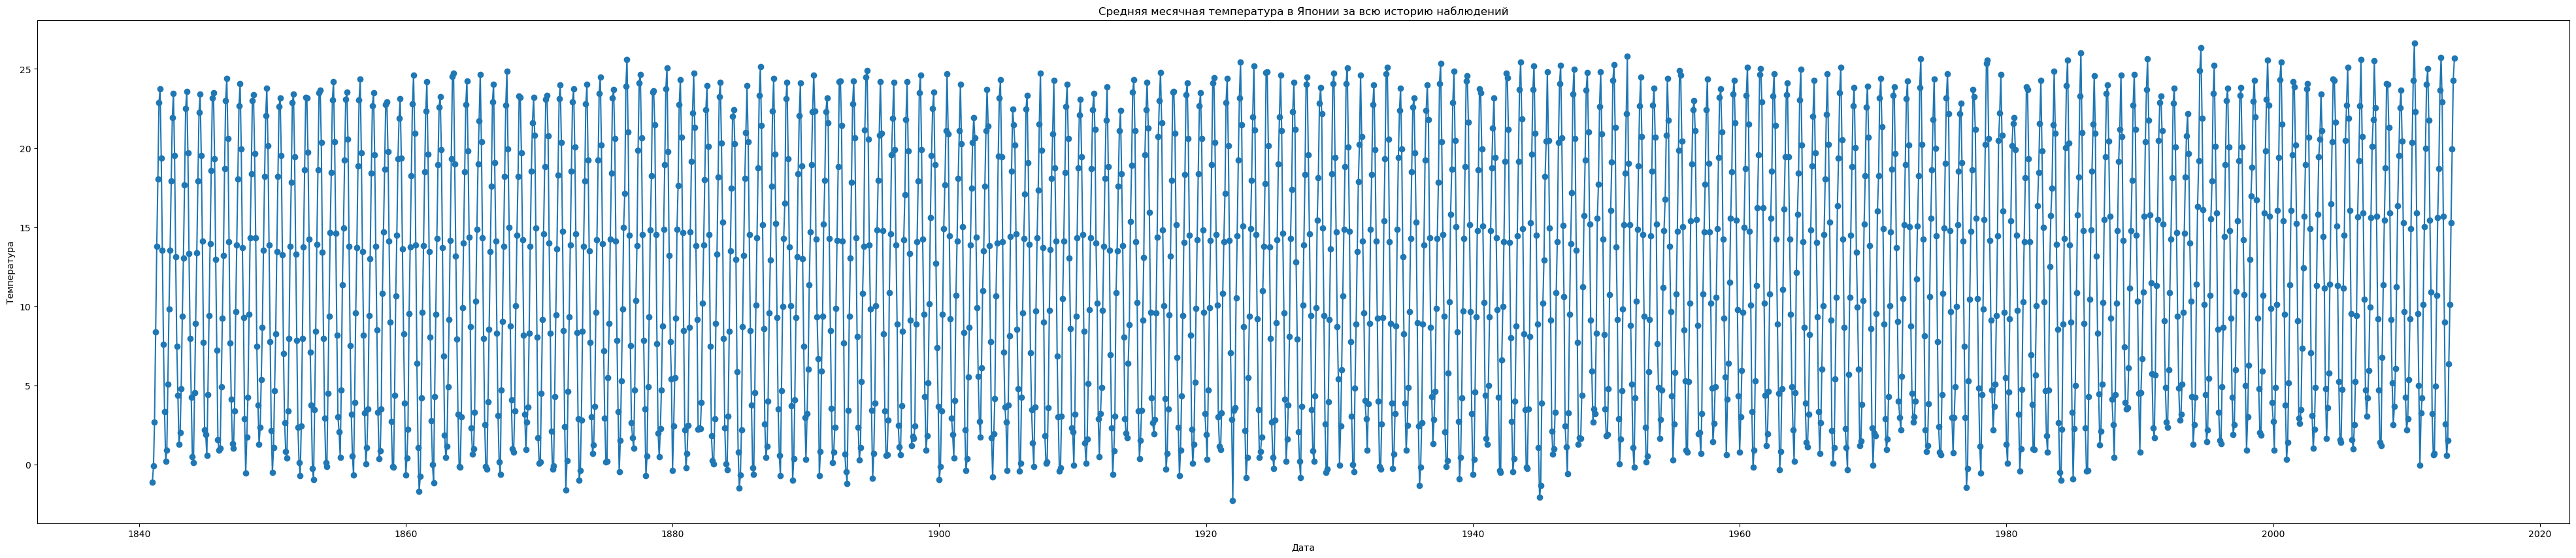

In [4]:
plt.figure(figsize=(50,10))
plt.plot(avg_temp_df.index, avg_temp_df['AverageTemperature'], marker = 'o')
plt.title("Средняя месячная температура в Японии за всю историю наблюдений")
plt.xlabel("Дата")
plt.ylabel("Температура")
plt.show()

Разделим временной ряд на обучающий и тестовые наборы.

Размер train: 1658, размер test: 415


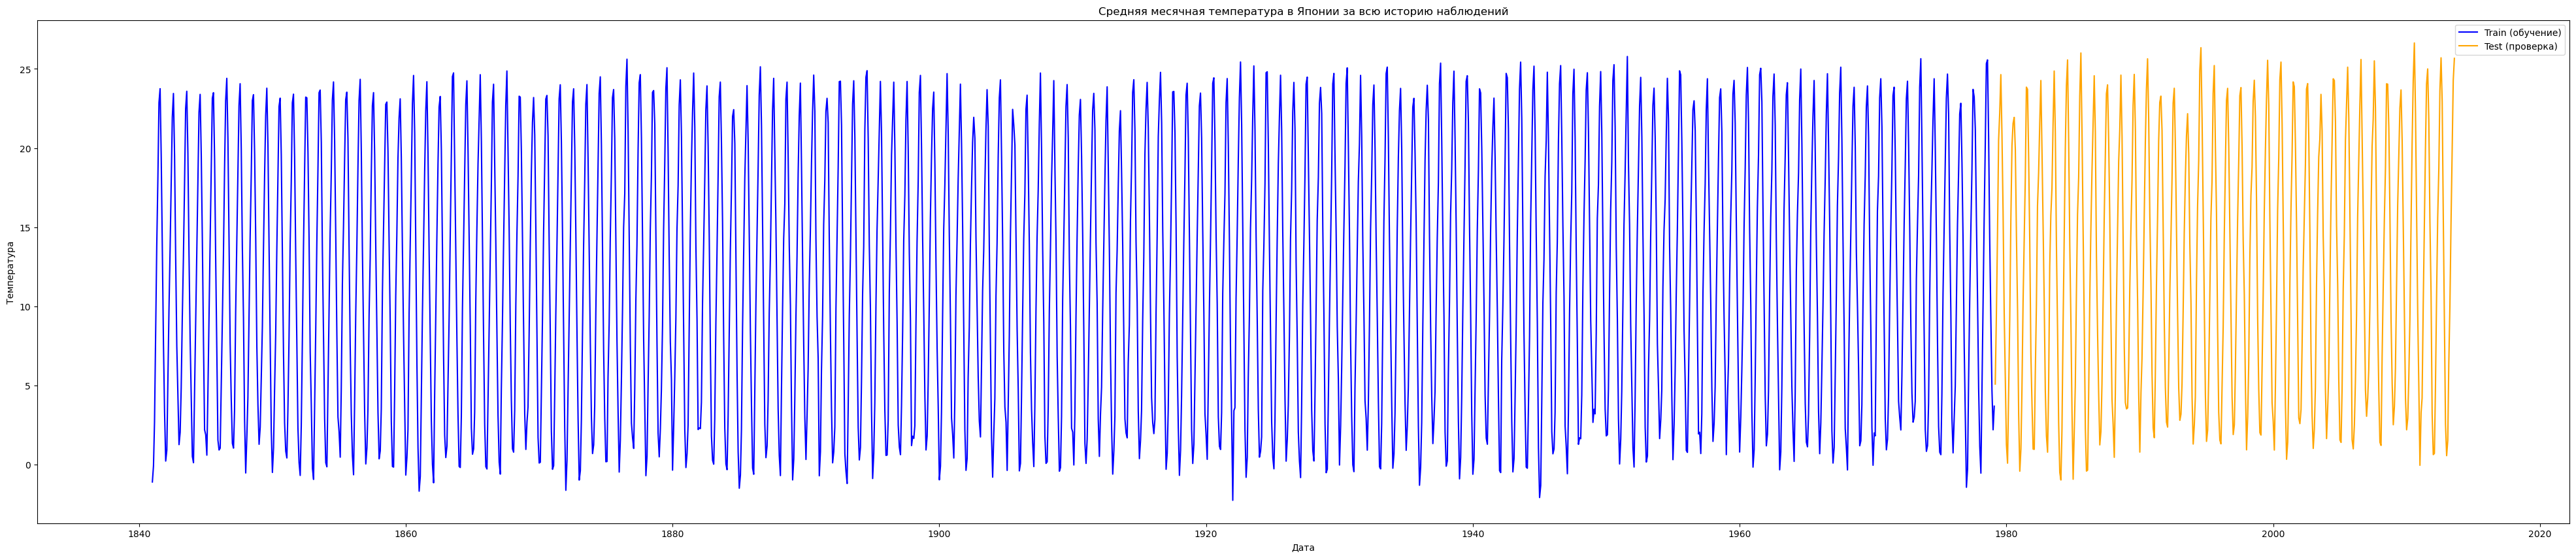

In [5]:
split_point = int(len(avg_temp_df) * 0.8)

train = avg_temp_df.iloc[:split_point]
test = avg_temp_df.iloc[split_point:]
print(f"Размер train: {len(train)}, размер test: {len(test)}")
plt.figure(figsize=(50,10))

plt.plot(train.index, train['AverageTemperature'], label='Train (обучение)', color='blue')
 
plt.plot(test.index, test['AverageTemperature'], label='Test (проверка)', color='orange')
 
plt.title("Средняя месячная температура в Японии за всю историю наблюдений")
plt.xlabel("Дата")
plt.ylabel("Температура")
plt.legend()
plt.show()

Реализуем rolling-window-разбиение. Обучающие отрезки длиной 120 месяцев (10 лет) и прогнозный горизонт 12 месяцев.

In [6]:
window_size = 120
horizon = 12

splits = []
for start in range(0, len(avg_temp_df) - window_size - horizon + 1, horizon):
	train_window = avg_temp_df.iloc[start:start+window_size]
	test_window = avg_temp_df.iloc[start+window_size:start+window_size+horizon]
	splits.append((train_window, test_window))

Визуализируем первые два сплита

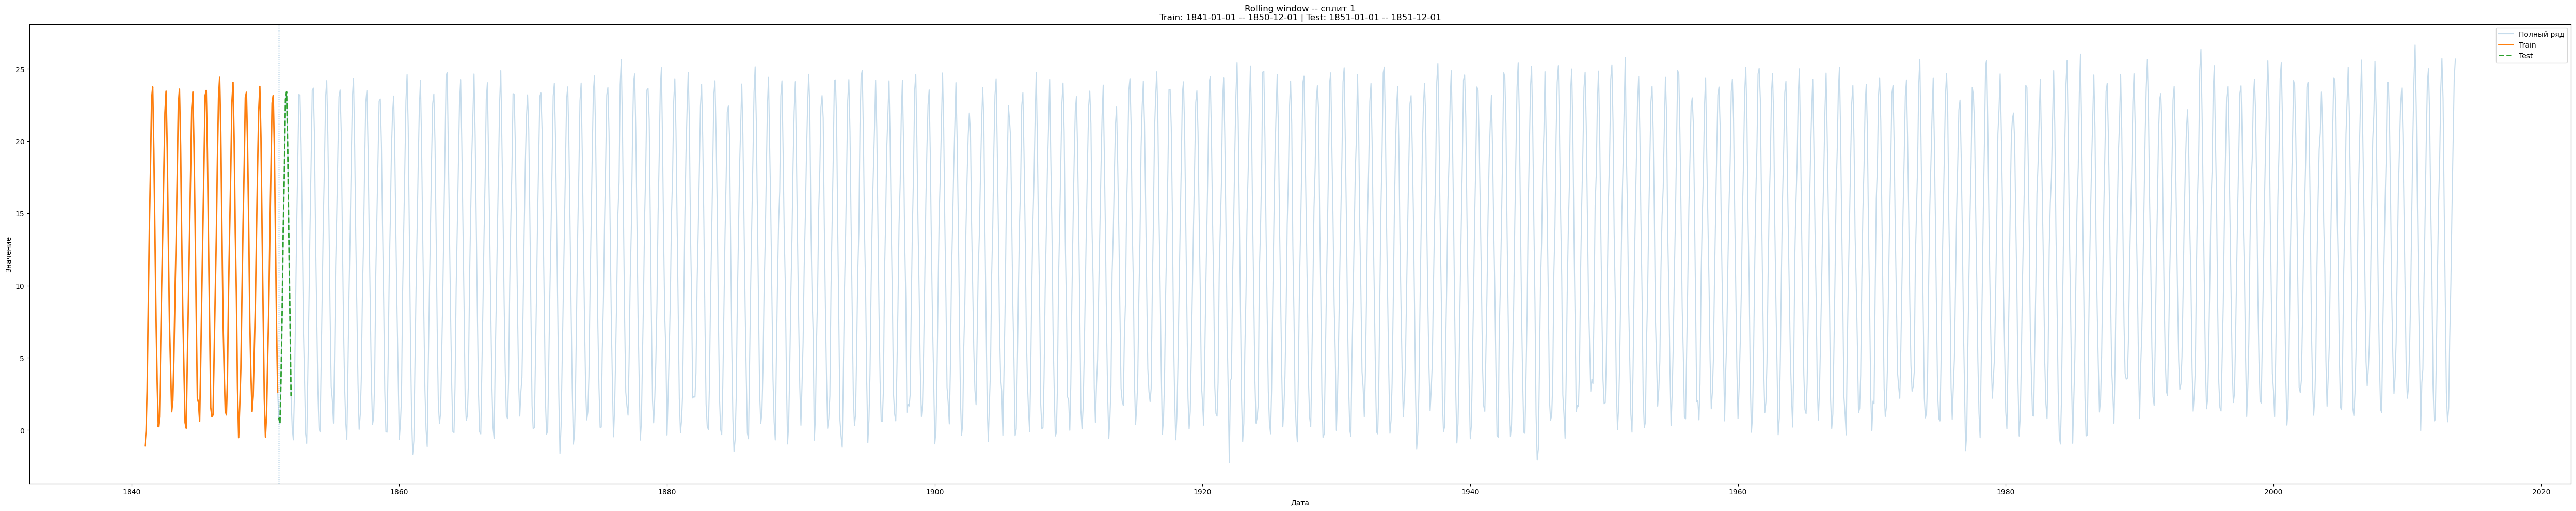

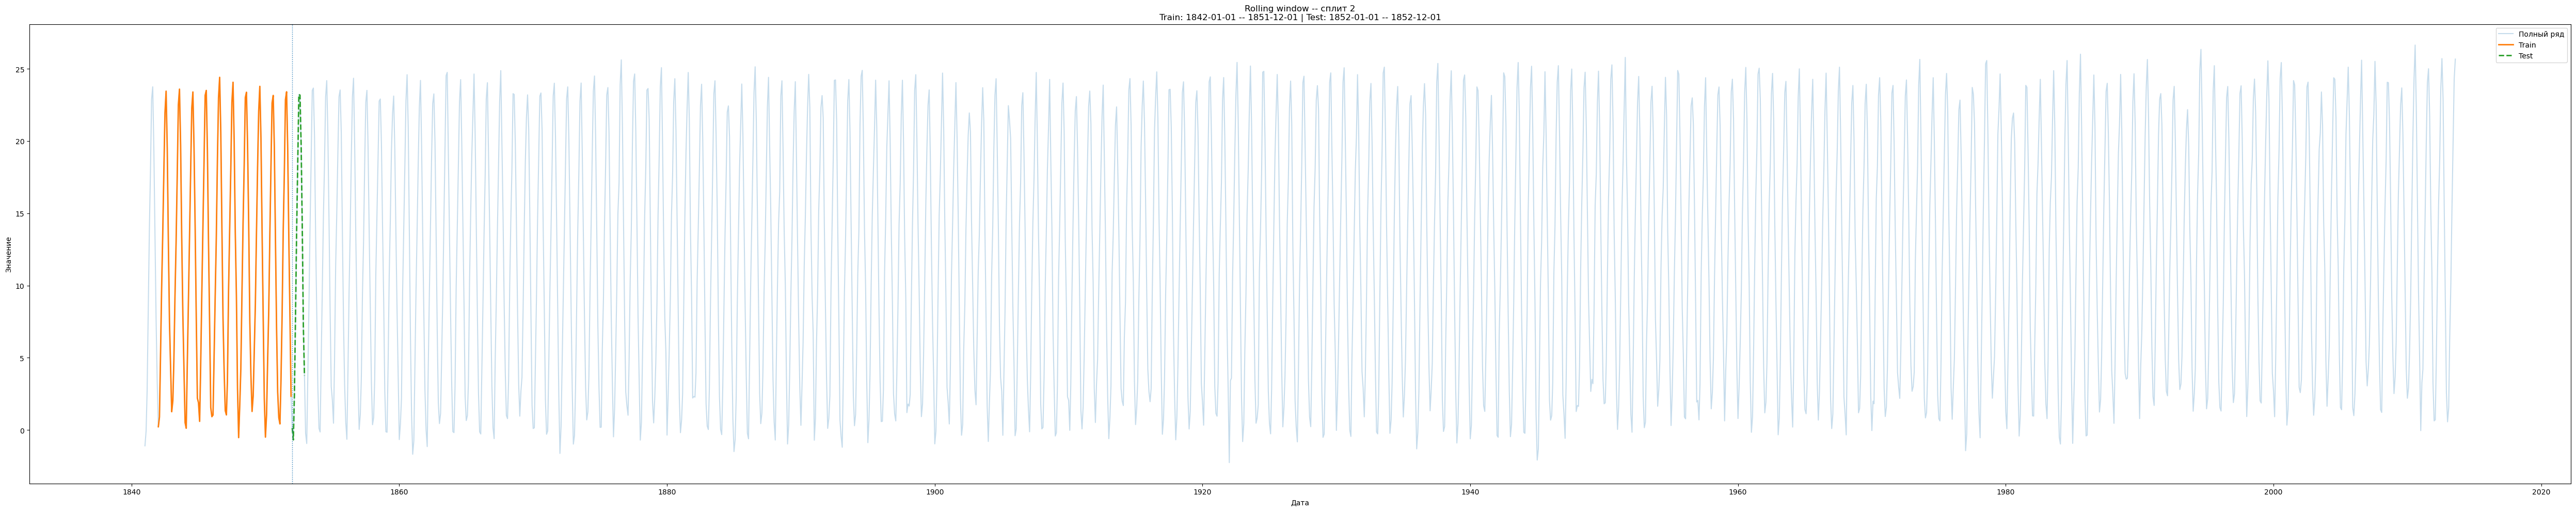

In [7]:
for i, (train_window, test_window) in enumerate(splits[:2], start=1):
	plt.figure(figsize=(50, 10))
	
	plt.plot(avg_temp_df.index, avg_temp_df['AverageTemperature'], alpha=0.25, label='Полный ряд')
	
	plt.plot(train_window.index, train_window['AverageTemperature'], linewidth=2, label='Train')
	
	plt.plot(test_window.index, test_window['AverageTemperature'], linewidth=2, linestyle='--', label='Test')
	
	plt.axvline(test_window.index[0], linestyle=':', linewidth=1)
 
	plt.title(f'Rolling window -- сплит {i}\n'
          	f'Train: {train_window.index[0].date()} -- {train_window.index[-1].date()} | '
          	f'Test: {test_window.index[0].date()} -- {test_window.index[-1].date()}')
	plt.xlabel('Дата')
	plt.ylabel('Значение')
	plt.legend()
	plt.tight_layout()
	plt.show()

Сгненрируем синтетические признаки: лаги на 1 и 12 месяцев и календарные признаки: номер месяца и индикатор зимнего сезона (декабрь — февраль).

In [8]:
avg_temp_df['lag1'] = avg_temp_df['AverageTemperature'].shift(1)
avg_temp_df['lag12'] = avg_temp_df['AverageTemperature'].shift(12)
avg_temp_df['month_number'] = avg_temp_df.index.month
avg_temp_df['is_winter'] = avg_temp_df['month_number'].isin([12, 1, 2]).astype(int)
avg_temp_df.head()

,AverageTemperature,lag1,lag12,month_number,is_winter
dt,,,,,
1841-01-01,-1.100,NaN,NaN,1,1
1841-02-01,-0.079,-1.100,NaN,2,1
1841-03-01,2.680,-0.079,NaN,3,0
1841-04-01,8.400,2.680,NaN,4,0
1841-05-01,13.796,8.400,NaN,5,0


Построим моедль линейной регрессии, где целевая переменная — температура, а признаки — лаги и дата-фичи.

In [9]:
# признаки и целевая переменная
features = ['lag1', 'lag12', 'month_number', 'is_winter']
target = 'AverageTemperature'


# перед подачей данных на обучение и тест, отчистим их от пустых значений и нужно заново разделить данные, так как у нас появились новые признаки после первого разбиения выше
avg_temp_df = avg_temp_df.dropna(subset=features + [target])

split_point = int(len(avg_temp_df) * 0.8)
train = avg_temp_df.iloc[:split_point]
test = avg_temp_df.iloc[split_point:]

X_train = sm.add_constant(train[features])  
y_train = train[target]

X_test = sm.add_constant(test[features])
y_test = test[target]

model = sm.OLS(y_train, X_train).fit()

pred = model.get_prediction(X_test)
pred_summary = pred.summary_frame(alpha=0.05) 

y_pred = pred_summary["mean"]
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")

MAE:  1.009
RMSE: 1.286
MAPE: 48.24%


Видим, что метрики достаточно MAE и RMSE достаточно хорошие (ошибка примерно на 1 градус), но MAPE достаточно большая. Так происходит в связи с тем, что в значениях есть достаточно много занчений близких к 0 градусам (в зимний период) и пр=оэтому ошибка в процентах сильно искажается.

Для наглядности выведем график прогноза и реальных занчений.

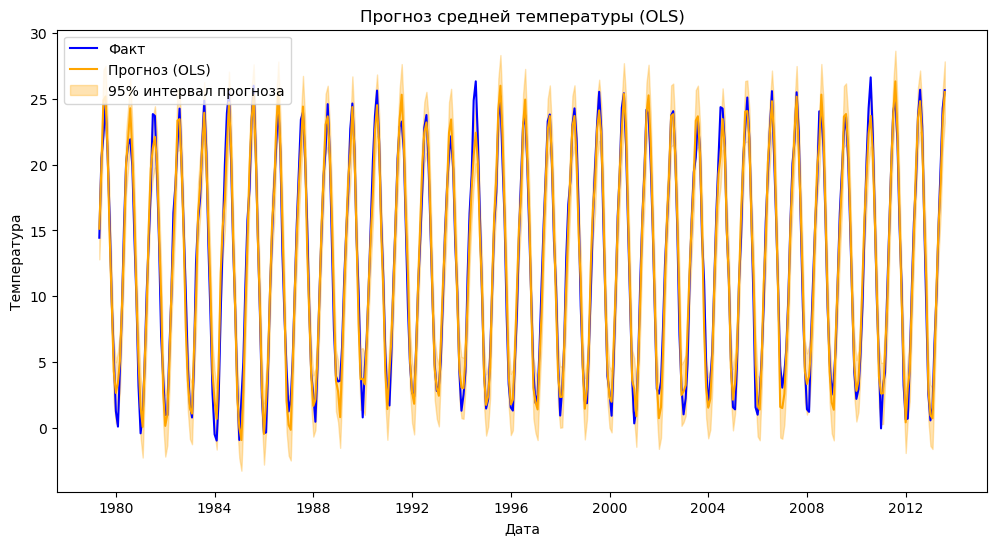

In [10]:
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Факт", color="blue")
plt.plot(y_test.index, y_pred, label="Прогноз (OLS)", color="orange")
plt.fill_between(y_test.index,
                 pred_summary["obs_ci_lower"],
                 pred_summary["obs_ci_upper"],
                 color="orange", alpha=0.3, label="95% интервал прогноза")
plt.title("Прогноз средней температуры (OLS)")
plt.xlabel("Дата")
plt.ylabel("Температура")
plt.legend()
plt.show()